In [1]:
import os
import time
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.svm import SVR

# import helperfunctions
from helperfunctions import fun_load_file, fun_preprocessing, fun_split_X_y
from helperfunctions import fun_train_score, fun_test_score, fun_best_model
from helperfunctions import plot_feature_importances

# load data
data = fun_load_file(path='01_data\\01_TSP', name='combined_train_instances_dennis.xlsx')
train_data = fun_preprocessing(data)
X, y = fun_split_X_y(train_data)

# create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=0)

# save number of features
n_features = X_train.shape[1]

# **Support Vector Machines and Kernel Machines**

**Scaling**

In [10]:
# standardscaler
standard = StandardScaler()

standard.fit(X_train)
X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

# minmaxscaler
minmax = MinMaxScaler()

minmax.fit(X_train)
X_train_minmax = minmax.transform(X_train)
X_test_minmax = minmax.transform(X_test)

# robustsclaer
robust = RobustScaler()

robust.fit(X_train)
X_train_robust = robust.transform(X_train)
X_test_robust = robust.transform(X_test)

X_train_dict = {'Standard scaler': X_train_standard, 
                'Minmax scaler': X_train_minmax,
                'Robust scaler': X_train_robust}

### **Gaussian Kernel**

----------Standard scaler----------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
MAPE on train data with {'C': 150, 'gamma': 0.01}: 4.04 %
Computation time: 26948.1 seconds

----------Minmax scaler----------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
MAPE on train data with {'C': 650, 'gamma': 0.1}: 3.51 %
Computation time: 25302.57 seconds

----------Robust scaler----------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
MAPE on train data with {'C': 500, 'gamma': 0.01}: 3.94 %
Computation time: 31375.32 seconds



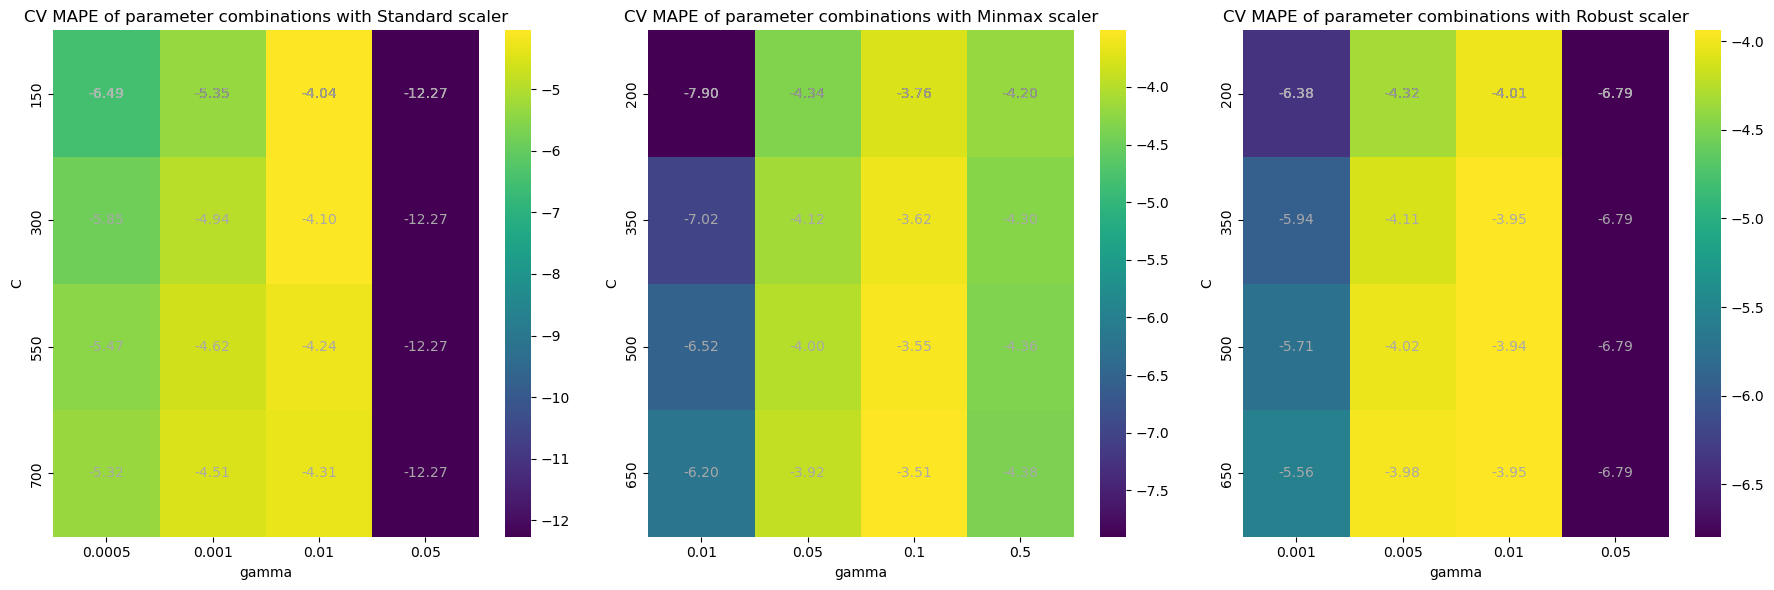

In [60]:
# grid search cross validation
param_grid = {'Standard scaler': {'C': [150, 300, 550, 700],#?
                                  'gamma': [0.0005, 0.001, 0.01, 0.05]},
              'Minmax scaler': {'C': [200, 350, 500, 650],
                                'gamma': [0.01, 0.05, 0.1, 0.5]},
              'Robust scaler': {'C': [200, 350, 500, 650],
                                'gamma': [0.001, 0.005, 0.01, 0.05]}}

scores_list = []

for scaler_name in list(X_train_dict.keys())[:3]:
    start = time.time()
    print('----------{}----------'.format(scaler_name))

    grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=False), param_grid=param_grid[scaler_name], cv=3,
                            scoring='neg_mean_absolute_percentage_error', 
                            verbose=True, n_jobs=-1)

    grid_search.fit(X_train_dict[scaler_name], y_train)

    # performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    n_rows = len(list(param_grid[scaler_name].values())[0])
    n_cols = len(list(param_grid[scaler_name].values())[1])
    scores_list.append(np.array(results_df['mean_test_score']).reshape(n_rows, n_cols) * 100)

    print('Computation time: {} seconds\n'.format(np.round(time.time()-start, 2)))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for scaler, ax in enumerate(axes):
    scores = scores_list[scaler]
    scaler_name = list(X_train_dict.keys())[scaler]
    
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[scaler_name]['gamma'], yticklabels=param_grid[scaler_name]['C'], ax=ax)
    
    # Annotating each cell with its corresponding score
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {}'.format(list(X_train_dict.keys())[scaler]))

plt.tight_layout()
plt.show()

----------Standard scaler----------
Fitting 3 folds for each of 4 candidates, totalling 12 fits
MAPE on train data with {'C': 150, 'gamma': 0.01}: 4.28 %
Computation time: 4991.47 seconds

----------Minmax scaler----------
Fitting 3 folds for each of 4 candidates, totalling 12 fits
MAPE on train data with {'C': 800, 'gamma': 0.1}: 3.58 %
Computation time: 5492.55 seconds

----------Robust scaler----------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
MAPE on train data with {'C': 650, 'gamma': 0.005}: 4.11 %
Computation time: 12625.04 seconds



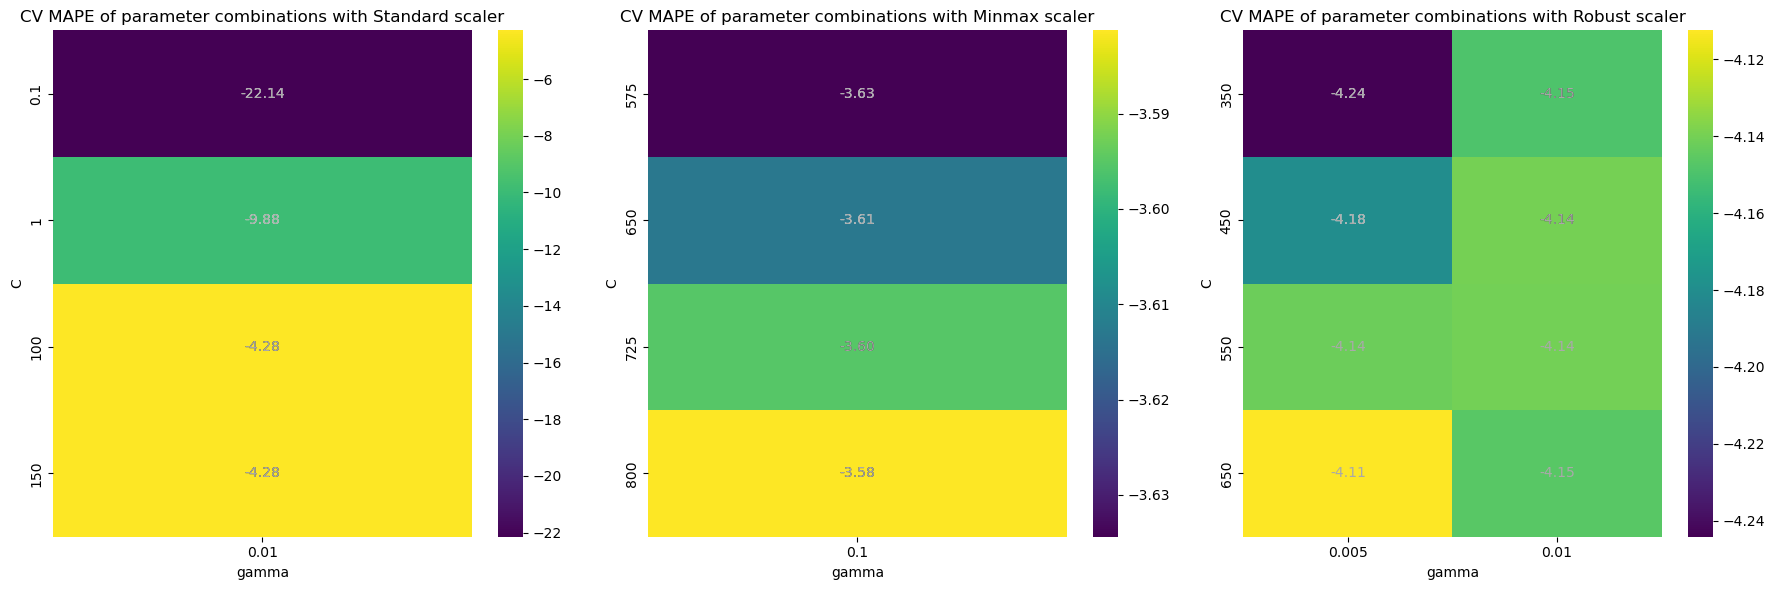

In [63]:
# grid search cross validation
param_grid = {'Standard scaler': {'C': [0.1, 1, 100, 150],
                                  'gamma': [0.01]},
              'Minmax scaler': {'C': [575, 650, 725, 800],
                                'gamma': [0.1]},
              'Robust scaler': {'C': [350, 450, 550, 650],
                                'gamma': [0.005, 0.01]}}

scores_list = []

for scaler_name in list(X_train_dict.keys())[:3]:
    start = time.time()
    print('----------{}----------'.format(scaler_name))

    grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=False), param_grid=param_grid[scaler_name], cv=3,
                            scoring='neg_mean_absolute_percentage_error', 
                            verbose=True, n_jobs=-1)

    grid_search.fit(X_train_dict[scaler_name], y_train)

    # performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    n_rows = len(list(param_grid[scaler_name].values())[0])
    n_cols = len(list(param_grid[scaler_name].values())[1])
    scores_list.append(np.array(results_df['mean_test_score']).reshape(n_rows, n_cols) * 100)

    print('Computation time: {} seconds\n'.format(np.round(time.time()-start, 2)))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for scaler, ax in enumerate(axes):
    scores = scores_list[scaler]
    scaler_name = list(X_train_dict.keys())[scaler]
    
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[scaler_name]['gamma'], yticklabels=param_grid[scaler_name]['C'], ax=ax)
    
    # Annotating each cell with its corresponding score
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {}'.format(list(X_train_dict.keys())[scaler]))

plt.tight_layout()
plt.show()

----------Standard scaler----------
Fitting 3 folds for each of 3 candidates, totalling 9 fits
MAPE on train data with {'C': 150, 'gamma': 0.01}: 4.04 %
Computation time: 12272.6 seconds

----------Minmax scaler----------
Fitting 3 folds for each of 4 candidates, totalling 12 fits
MAPE on train data with {'C': 1000, 'gamma': 0.1}: 3.45 %
Computation time: 16949.16 seconds

----------Robust scaler----------
Fitting 3 folds for each of 8 candidates, totalling 24 fits
MAPE on train data with {'C': 450, 'gamma': 0.01}: 3.94 %
Computation time: 42548.68 seconds



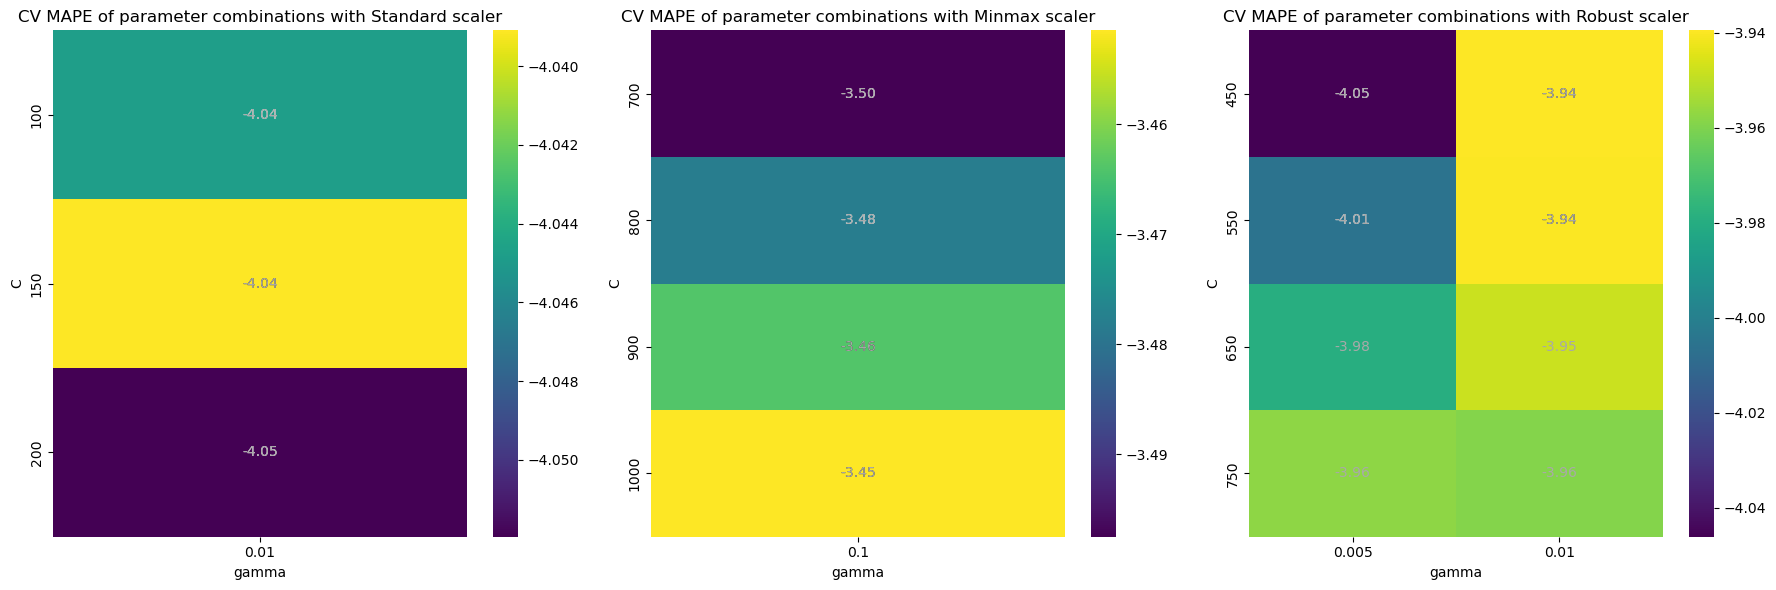

In [11]:
# grid search cross validation
param_grid = {'Standard scaler': {'C': [100, 150, 200],
                                  'gamma': [0.01]},
              'Minmax scaler': {'C': [700, 800, 900, 1000],
                                'gamma': [0.1]},
              'Robust scaler': {'C': [450, 550, 650, 750],
                                'gamma': [0.005, 0.01]}}

scores_list = []

for scaler_name in list(X_train_dict.keys())[:3]:
    start = time.time()
    print('----------{}----------'.format(scaler_name))

    grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=False), param_grid=param_grid[scaler_name], cv=3,
                            scoring='neg_mean_absolute_percentage_error', 
                            verbose=True, n_jobs=-1)

    grid_search.fit(X_train_dict[scaler_name], y_train)

    # performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    n_rows = len(list(param_grid[scaler_name].values())[0])
    n_cols = len(list(param_grid[scaler_name].values())[1])
    scores_list.append(np.array(results_df['mean_test_score']).reshape(n_rows, n_cols) * 100)

    print('Computation time: {} seconds\n'.format(np.round(time.time()-start, 2)))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for scaler, ax in enumerate(axes):
    scores = scores_list[scaler]
    scaler_name = list(X_train_dict.keys())[scaler]
    
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid[scaler_name]['gamma'], yticklabels=param_grid[scaler_name]['C'], ax=ax)
    
    # Annotating each cell with its corresponding score
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='darkgrey')

    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {}'.format(list(X_train_dict.keys())[scaler]))

plt.tight_layout()
plt.show()

**Best scaler only**

In [ ]:
# grid search cross validation
scaler = 'robust'

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 200, 300, 400, 500],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(estimator=SVR(kernel='rbf', verbose=10), param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_percentage_error', 
                           verbose=10, n_jobs=-1)
grid_search.fit(X_train_dict[scaler], y_train)

# view cv scores of parameter combinations
print('Cross validation scores of different parameter combinations:')
results_df = pd.DataFrame(grid_search.cv_results_)
#display(results_df[['params', 'mean_test_score']])

# get best parameters
print('\nBest model:')
display(grid_search.best_estimator_)

# performance evaluation - compare train and test score
print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[LibSVM]Cross validation scores of different parameter combinations:

Best model:


SVR(C=500, gamma=0.01, verbose=10)

MAPE on train data with {'C': 500, 'gamma': 0.01}: 10.44 %


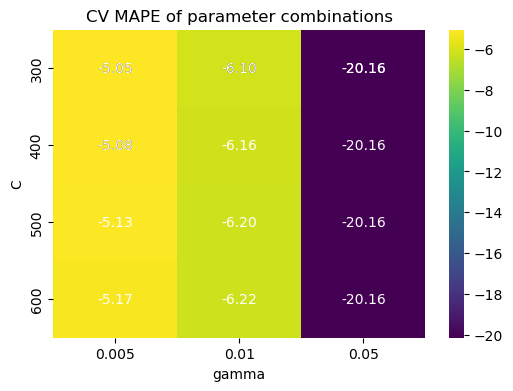

In [ ]:
# reshape mean cv test scores
scores = np.array(results_df['mean_test_score']).reshape(4, 3) * 100

# Plotting the heatmap with scores displayed above
plt.figure(figsize=(6, 4))
sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid['gamma'], yticklabels=param_grid['C'])

# Annotating each cell with its corresponding score
for i in range(len(scores)):
    for j in range(len(scores[i])):
        text = plt.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='white')

plt.xlabel('gamma')
plt.ylabel('C')
plt.title('CV MAPE of parameter combinations')

plt.show()

### **Polynomial Kernel**

In [9]:
grid_search = GridSearchCV(estimator=SVR(kernel='poly', verbose=10), param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_percentage_error', 
                           verbose=10, n_jobs=-1)
grid_search.fit(X_train_dict['robust'], y_train)

# view cv scores of parameter combinations
print('Cross validation scores of different parameter combinations:')
results_df = pd.DataFrame(grid_search.cv_results_)
display(results_df[['params', 'mean_test_score']])

# get best parameters
print('\nBest model:')
display(grid_search.best_estimator_)

# performance evaluation - compare train and test score
print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LibSVM]Cross validation scores of different parameter combinations:


,params,mean_test_score
0,"{'C': 0.1, 'degree': 2, 'gamma': 0.1}",-0.679802
1,"{'C': 0.1, 'degree': 2, 'gamma': 1}",-0.353104
2,"{'C': 0.1, 'degree': 2, 'gamma': 10}",-0.364074
3,"{'C': 0.1, 'degree': 3, 'gamma': 0.1}",-0.482018
4,"{'C': 0.1, 'degree': 3, 'gamma': 1}",-0.378720
5,"{'C': 0.1, 'degree': 3, 'gamma': 10}",-0.378720
6,"{'C': 0.1, 'degree': 4, 'gamma': 0.1}",-0.647349
7,"{'C': 0.1, 'degree': 4, 'gamma': 1}",-0.583615
8,"{'C': 0.1, 'degree': 4, 'gamma': 10}",-0.583614
9,"{'C': 1, 'degree': 2, 'gamma': 0.1}",-0.476115



Best model:


SVR(C=0.1, degree=2, gamma=1, kernel='poly', verbose=10)

MAPE on train data with {'C': 0.1, 'degree': 2, 'gamma': 1}: 35.31 %


In [12]:
# grid search cross validation
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], #regularization parameter
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], #coefficient for the kernel function
              'degree': [2, 3, 4]} #degree of the polynomial kernel

grid_search = GridSearchCV(estimator=SVR(kernel='poly', verbose=False), param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_percentage_error', 
                           verbose=False, n_jobs=-1)

results_list = []

for i in list(X_train_dict.keys())[:3]:
    print(i)

    grid_search.fit(X_train_dict[i], y_train)

    # performance evaluation - compare train and test score
    print('MAPE on train data with {}: {} %\n'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

    # reshape mean cv test scores
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_list.append(results_df)

Standard scaler scaler:
MAPE on train data with {'C': 0.1, 'degree': 3, 'gamma': 0.1}: 33.3 %

Minmax scaler scaler:
MAPE on train data with {'C': 0.001, 'degree': 3, 'gamma': 10}: 9.66 %

Robust scaler scaler:
MAPE on train data with {'C': 0.001, 'degree': 2, 'gamma': 10}: 35.31 %



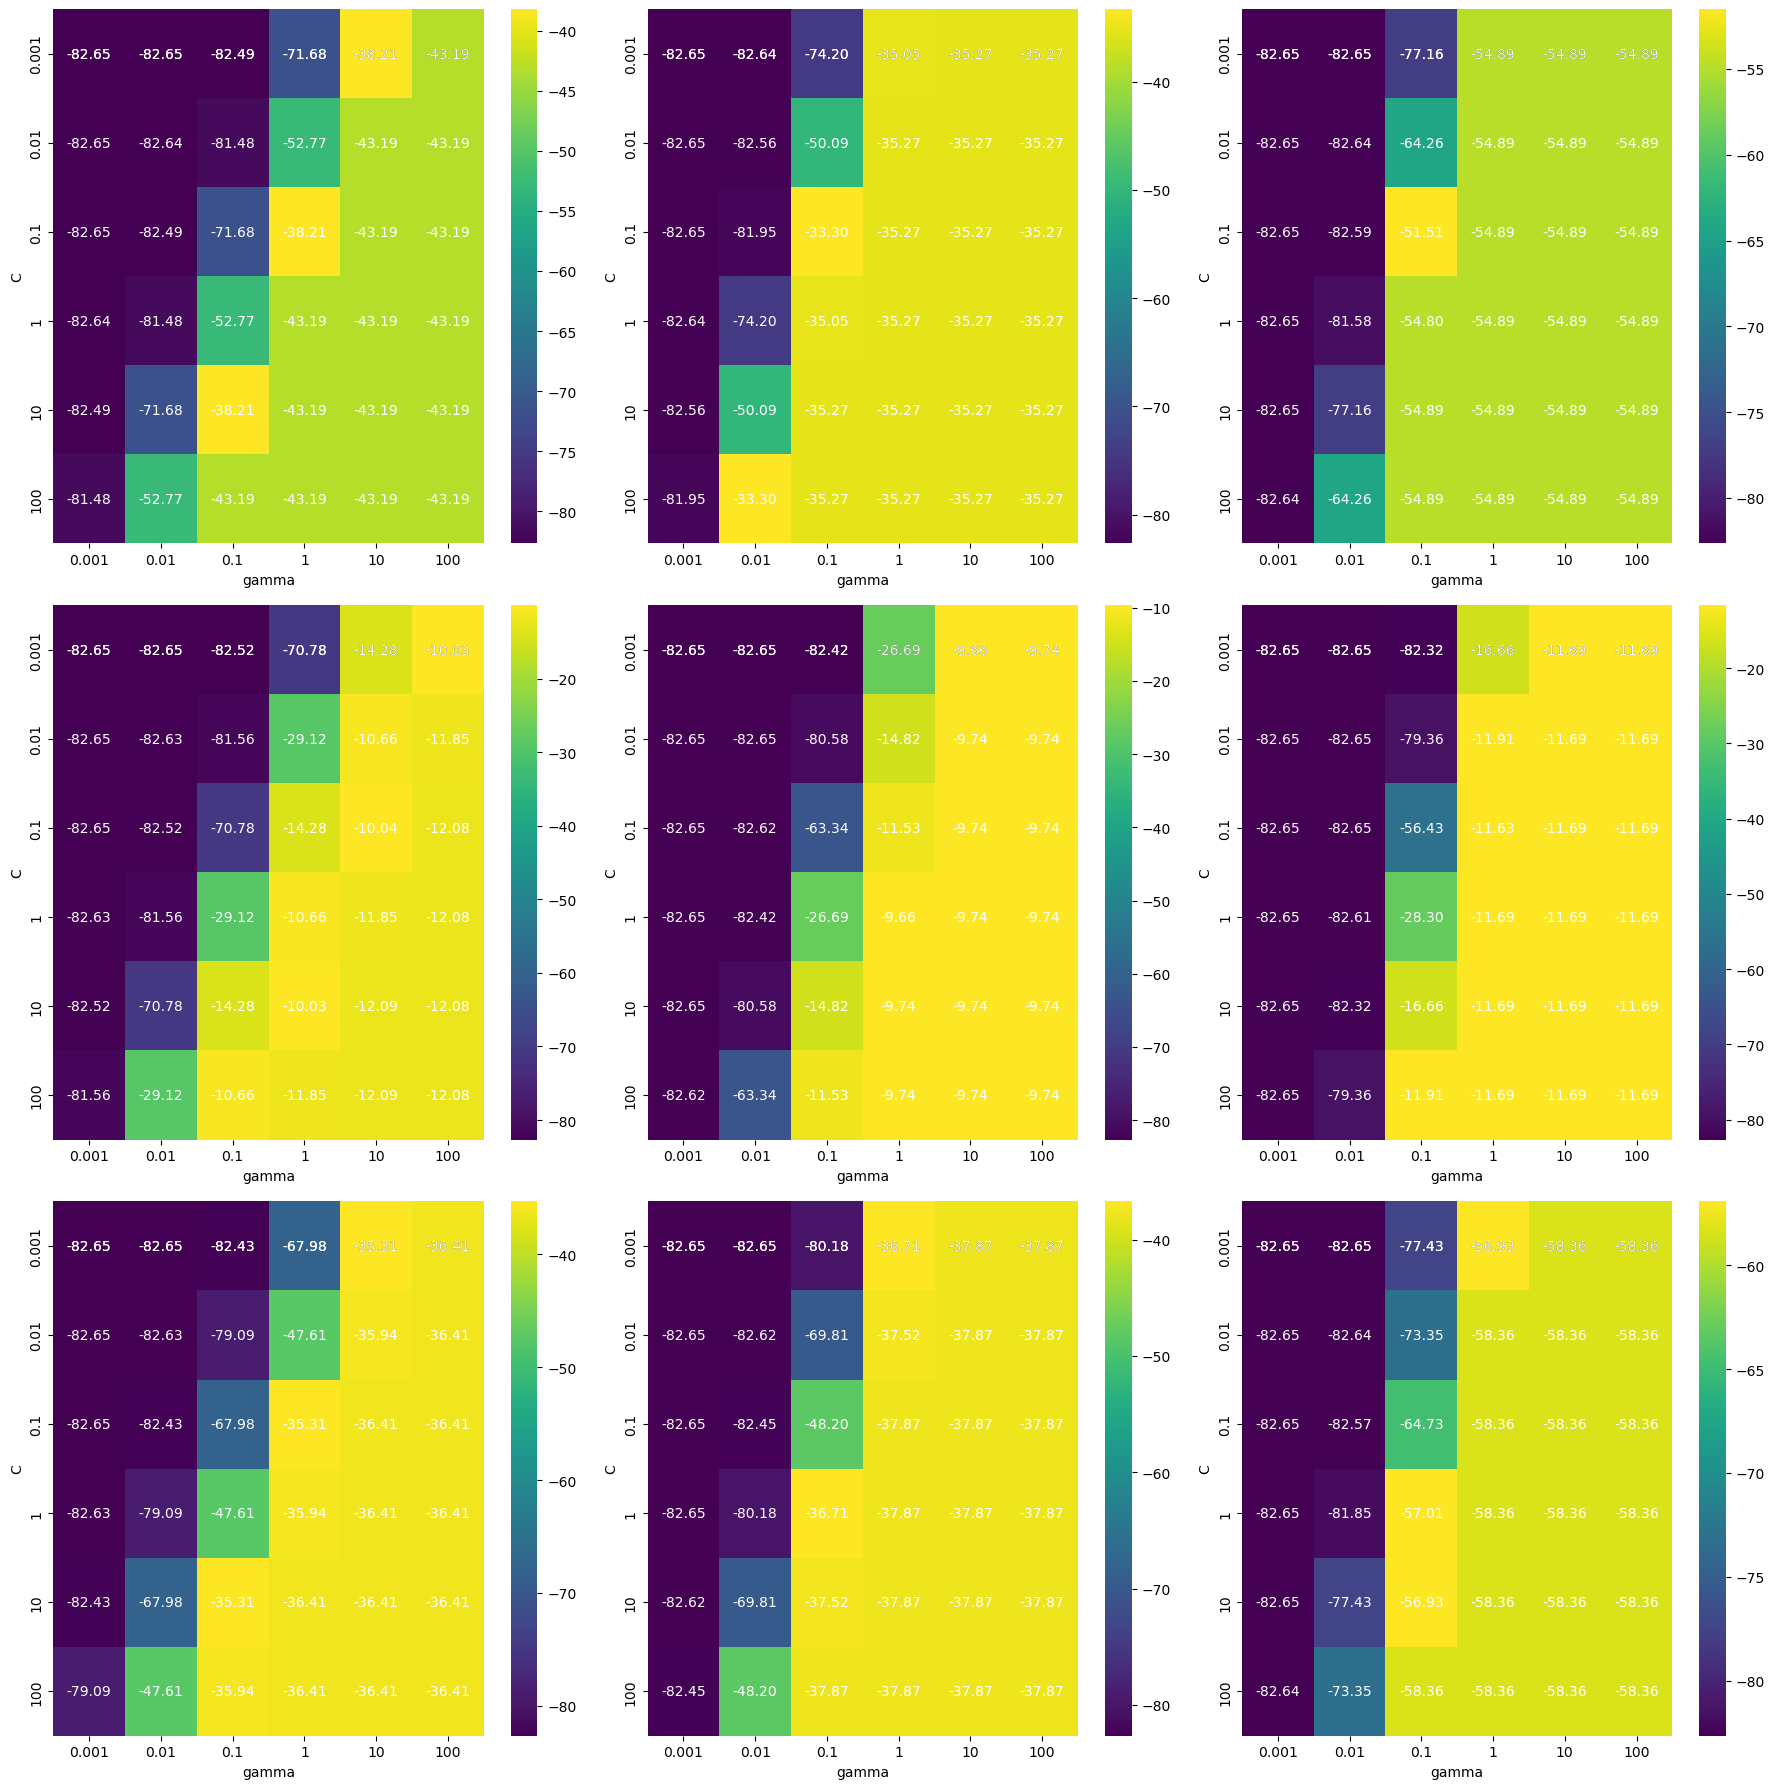

In [35]:
# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

for i, ax in enumerate(axes):
    scores = scores_list[i]

    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], ax=ax)

    # annotating each cell with its corresponding score
    for i in range(len(scores)):
       for j in range(len(scores[i])):
           text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='white')
    
    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    #ax.set_title('CV MAPE of parameter combinations with {} scaler'.format(list(X_train_dict.keys())[scaler]))

    # Set column labels
    ax.set_xticklabels(param_grid['gamma'])

    # Set row labels
    ax.set_yticklabels(param_grid['C'])

plt.tight_layout()
plt.show()

In [ ]:
def add_scores(group):
    scores_list.append(np.array(group['mean_test_score']).reshape(6, 6) * 100)


def create_heatmap(group, ax):
    scores = np.array(group['mean_test_score']).reshape(6, 6) * 100
    sns.heatmap(scores, annot=True, fmt=".2f", cmap='viridis', xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], ax=ax)

    # annotating each cell with its corresponding score
    for i in range(len(scores)):
       for j in range(len(scores[i])):
           text = ax.text(j + 0.5, i + 0.5, f"{scores[i, j]:.2f}", ha='center', va='center', color='white')
    
    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_title('CV MAPE of parameter combinations with {} scaler'.format(list(X_train_dict.keys())[scaler]))

In [ ]:
scores_list = []
for df in results_list:
    df.groupby(by='param_degree').apply(add_scores)


# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

for scaler, ax in enumerate(axes):
    results_df = results_list[scaler]
    results_df.groupby(by='param_degree').apply(create_heatmap, ax=ax)

plt.tight_layout()
plt.show()

### **Gaussian & Polynomial Kernel**

In [32]:
# grid search cross validation
param_grid = [{'kernel': ['rbf'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100], #regularization parameter
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100], #coefficient for the kernel function
              'degree': [2, 3, 4]}]  #degree of the polynomial kernel

grid_search = GridSearchCV(estimator=SVR(verbose=10), param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_percentage_error', 
                           verbose=10, n_jobs=-1)
grid_search.fit(X_train_dict['Robust scaler'], y_train)

# view cv scores of parameter combinations
print('Cross validation scores of different parameter combinations:')
results_df = pd.DataFrame(grid_search.cv_results_)
display(results_df[['params', 'mean_test_score']])

# get best parameters
print('\nBest model:')
display(grid_search.best_estimator_)

# performance evaluation - compare train and test score
print('MAPE on train data with {}: {} %'.format(grid_search.best_params_, np.round(-100 * grid_search.best_score_, 2))) #cv score of best parameter combination

Fitting 3 folds for each of 36 candidates, totalling 108 fits
